In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from skew_correction.data import DatasetClass, MyDataModule, plot_random_images
from skew_correction.model import MyModelModule, TimmClassifier, total_params
from skew_correction.constants import root_dir, device
from skew_correction.train_utils import checkpoint_callback, early_stop_callback

import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from pytz import timezone  # This library helps you get the timezone if needed

/home/deepam_minda_farmart_co/anaconda3/envs/vqa/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device

device(type='cuda')

## data

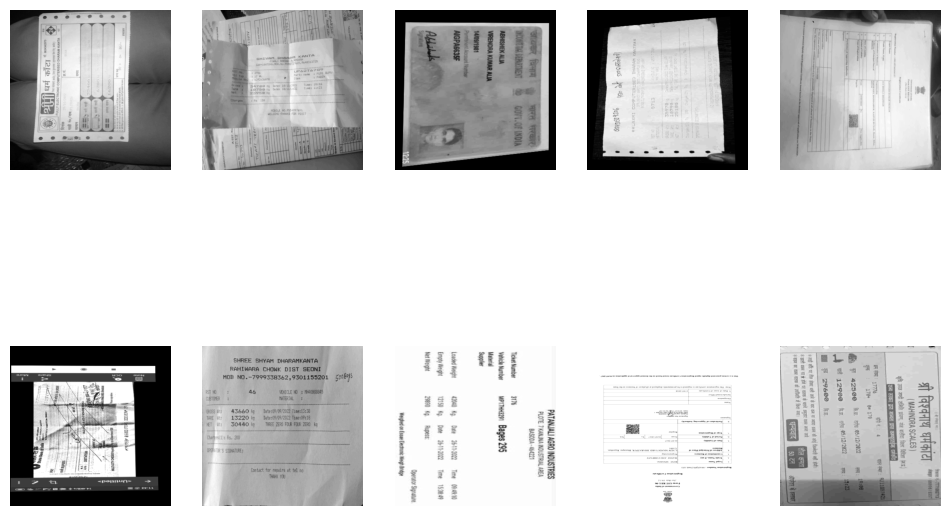

In [4]:
## load dataset
dataset = DatasetClass("/home/deepam_minda_farmart_co/fmt/skew_correction/data/train_data.csv", split='train')
plot_random_images(dataset)
pl_data = MyDataModule(dataset, train_bs=32, val_bs=8)

In [5]:
## check data sizes
pl_data.setup()
tdl = pl_data.train_dataloader()
vdl = pl_data.val_dataloader()
print(f"len of dataloader = {len(tdl)}, batchsize = {tdl.batch_size} \ntotal samples = {len(tdl)*tdl.batch_size}")
print(f"len of dataloader = {len(vdl)}, batchsize = {vdl.batch_size} \ntotal samples = {len(vdl)*vdl.batch_size}")

len of dataloader = 24, batchsize = 32 
total samples = 768
len of dataloader = 24, batchsize = 8 
total samples = 192


## train


In [6]:
# import timm 
# timm.list_models("mobile*")
# model = timm.create_model("mobilenetv3_large_100")
# total_params(model)
# # 

In [7]:
## load model

lr = 0.0001
loss_fn = torch.nn.CrossEntropyLoss()

model_string = 'densenet121'
dropout=0.3
model = TimmClassifier(model_string, dropout=dropout)
print(f"total_params: {total_params(model)}")

pl_model = MyModelModule(model, loss_fn, lr)


total_params: 6951684


In [9]:
verbose=False

# Get the current date and time in a specific format
current_date = datetime.now(timezone('Asia/Kolkata')).strftime('%Y-%m-%d')

tb_logger = TensorBoardLogger(
    save_dir=os.path.join(root_dir, 'logs'), 
    name=f"{current_date}-{model_string}-{round(total_params(model)/1000000,2)}m_params-{len(tdl)*tdl.batch_size}samples-lr{lr}-bs{tdl.batch_size}-cpu-drop{dropout}"
)
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(root_dir, 'checkpoints'),
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}-{model_string}"
)

print(tb_logger.name)
trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=50, 
        logger=tb_logger, 
        log_every_n_steps=1, 
        limit_train_batches=None, 
        limit_val_batches=None,
        enable_checkpointing=True,
        callbacks=[checkpoint_callback, early_stop_callback],
    )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2023-08-02-densenet121-6.95m_params-768samples-lr0.0001-bs32-cpu-drop0.3


In [10]:
trainer.fit(pl_model, datamodule=pl_data)

# pl_model.trainer.callback_metrics

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | model   | TimmClassifier   | 7.0 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.807    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]==========> Epoch 0
{'val_loss': 1.4, 'val_acc': 0.25, 'val_acc_epoch': 0.25}
Epoch 0: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it, loss=1.27, v_num=1]==========> Epoch 0
{'train_loss': 1.16, 'train_acc': 0.54, 'train_acc_step': 0.54, 'val_loss': 1.2, 'val_acc': 0.43, 'val_acc_epoch': 0.43}
Epoch 0: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it, loss=1.27, v_num=1]

Metric val_loss improved. New best score: 1.196


Epoch 1: 100%|██████████| 48/48 [02:05<00:00,  2.61s/it, loss=0.89, v_num=1] ==========> Epoch 1
{
    "train_loss": 0.86,
    "train_acc_epoch": 0.36,
    "val_loss": 0.85,
    "val_acc_epoch": 0.59
}
Epoch 1: 100%|██████████| 48/48 [02:05<00:00,  2.61s/it, loss=0.89, v_num=1]

Metric val_loss improved by 0.347 >= min_delta = 0.0. New best score: 0.849


Epoch 2: 100%|██████████| 48/48 [03:01<00:00,  3.78s/it, loss=0.616, v_num=1]  ==========> Epoch 2
{
    "train_loss": 0.49,
    "train_acc_epoch": 0.66,
    "val_loss": 0.66,
    "val_acc_epoch": 0.74
}
Epoch 2: 100%|██████████| 48/48 [03:01<00:00,  3.78s/it, loss=0.616, v_num=1]

Metric val_loss improved by 0.192 >= min_delta = 0.0. New best score: 0.657


Epoch 3: 100%|██████████| 48/48 [03:57<00:00,  4.94s/it, loss=0.41, v_num=1]   ==========> Epoch 3
{
    "train_loss": 0.29,
    "train_acc_epoch": 0.81,
    "val_loss": 0.47,
    "val_acc_epoch": 0.85
}
Epoch 3: 100%|██████████| 48/48 [03:57<00:00,  4.94s/it, loss=0.41, v_num=1]

Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 0.467


Epoch 4: 100%|██████████| 48/48 [04:52<00:00,  6.10s/it, loss=0.242, v_num=1]  ==========> Epoch 4
{
    "train_loss": 0.19,
    "train_acc_epoch": 0.91,
    "val_loss": 0.27,
    "val_acc_epoch": 0.92
}
Epoch 4: 100%|██████████| 48/48 [04:52<00:00,  6.10s/it, loss=0.242, v_num=1]

Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 0.270


Epoch 5: 100%|██████████| 48/48 [05:48<00:00,  7.26s/it, loss=0.143, v_num=1]  ==========> Epoch 5
{
    "train_loss": 0.12,
    "train_acc_epoch": 0.97,
    "val_loss": 0.24,
    "val_acc_epoch": 0.91
}
Epoch 5: 100%|██████████| 48/48 [05:48<00:00,  7.26s/it, loss=0.143, v_num=1]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.236


Epoch 6: 100%|██████████| 48/48 [06:44<00:00,  8.43s/it, loss=0.0827, v_num=1] ==========> Epoch 6
{
    "train_loss": 0.09,
    "train_acc_epoch": 0.98,
    "val_loss": 0.18,
    "val_acc_epoch": 0.95
}
Epoch 6: 100%|██████████| 48/48 [06:44<00:00,  8.43s/it, loss=0.0827, v_num=1]

Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.180


Epoch 7: 100%|██████████| 48/48 [07:40<00:00,  9.58s/it, loss=0.0637, v_num=1]  ==========> Epoch 7
{
    "train_loss": 0.05,
    "train_acc_epoch": 0.99,
    "val_loss": 0.17,
    "val_acc_epoch": 0.95
}
Epoch 7: 100%|██████████| 48/48 [07:40<00:00,  9.58s/it, loss=0.0637, v_num=1]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.169


Epoch 8: 100%|██████████| 48/48 [08:35<00:00, 10.74s/it, loss=0.0426, v_num=1]  ==========> Epoch 8
{
    "train_loss": 0.05,
    "train_acc_epoch": 0.99,
    "val_loss": 0.13,
    "val_acc_epoch": 0.97
}
Epoch 8: 100%|██████████| 48/48 [08:35<00:00, 10.74s/it, loss=0.0426, v_num=1]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.132


Epoch 9: 100%|██████████| 48/48 [09:32<00:00, 11.93s/it, loss=0.0315, v_num=1]  ==========> Epoch 9
{
    "train_loss": 0.03,
    "train_acc_epoch": 1.0,
    "val_loss": 0.15,
    "val_acc_epoch": 0.96
}
Epoch 10: 100%|██████████| 48/48 [10:27<00:00, 13.08s/it, loss=0.0252, v_num=1]  ==========> Epoch 10
{
    "train_loss": 0.03,
    "train_acc_epoch": 1.0,
    "val_loss": 0.13,
    "val_acc_epoch": 0.96
}
Epoch 10: 100%|██████████| 48/48 [10:27<00:00, 13.08s/it, loss=0.0252, v_num=1]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.130


Epoch 11: 100%|██████████| 48/48 [11:22<00:00, 14.23s/it, loss=0.0226, v_num=1]  ==========> Epoch 11
{
    "train_loss": 0.02,
    "train_acc_epoch": 1.0,
    "val_loss": 0.1,
    "val_acc_epoch": 0.97
}
Epoch 11: 100%|██████████| 48/48 [11:22<00:00, 14.23s/it, loss=0.0226, v_num=1]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.098


Epoch 12: 100%|██████████| 48/48 [12:18<00:00, 15.39s/it, loss=0.0157, v_num=1]  ==========> Epoch 12
{
    "train_loss": 0.01,
    "train_acc_epoch": 1.0,
    "val_loss": 0.1,
    "val_acc_epoch": 0.98
}
Epoch 12: 100%|██████████| 48/48 [12:18<00:00, 15.39s/it, loss=0.0157, v_num=1]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.097


Epoch 13: 100%|██████████| 48/48 [13:13<00:00, 16.54s/it, loss=0.0128, v_num=1]  ==========> Epoch 13
{
    "train_loss": 0.01,
    "train_acc_epoch": 1.0,
    "val_loss": 0.07,
    "val_acc_epoch": 0.98
}
Epoch 13: 100%|██████████| 48/48 [13:13<00:00, 16.54s/it, loss=0.0128, v_num=1]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.072


Epoch 14: 100%|██████████| 48/48 [14:10<00:00, 17.71s/it, loss=0.00996, v_num=1]  ==========> Epoch 14
{
    "train_loss": 0.01,
    "train_acc_epoch": 1.0,
    "val_loss": 0.09,
    "val_acc_epoch": 0.97
}
Epoch 15: 100%|██████████| 48/48 [15:05<00:00, 18.86s/it, loss=0.00848, v_num=1]   ==========> Epoch 15
{
    "train_loss": 0.01,
    "train_acc_epoch": 1.0,
    "val_loss": 0.1,
    "val_acc_epoch": 0.97
}
Epoch 16: 100%|██████████| 48/48 [16:01<00:00, 20.04s/it, loss=0.00861, v_num=1]   ==========> Epoch 16
{
    "train_loss": 0.01,
    "train_acc_epoch": 1.0,
    "val_loss": 0.11,
    "val_acc_epoch": 0.96
}
Epoch 17: 100%|██████████| 48/48 [16:57<00:00, 21.20s/it, loss=0.00719, v_num=1]   ==========> Epoch 17
{
    "train_loss": 0.01,
    "train_acc_epoch": 1.0,
    "val_loss": 0.1,
    "val_acc_epoch": 0.98
}
Epoch 18: 100%|██████████| 48/48 [17:52<00:00, 22.35s/it, loss=0.00618, v_num=1]    ==========> Epoch 18
{
    "train_loss": 0.0,
    "train_acc_epoch": 1.0,
    "val_loss

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.072. Signaling Trainer to stop.


Epoch 18: 100%|██████████| 48/48 [17:52<00:00, 22.35s/it, loss=0.00618, v_num=1]
